## Latent Semantic Analysis using Gensim - datacamp blog

In [1]:
import warnings  
warnings.filterwarnings('ignore')

#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pandas as pd

### Loading data

In [2]:
df = pd.read_csv('../CSV/prep_songs.csv', header=0, index_col=0)
df.head()

,title_pl,txt_pl,txt_en,title_pl_tokenized,txt_pl_tokenized,txt_en_tokenized,title_pl_tokenized_lower_nostops,txt_pl_tokenized_lower_nostops,txt_en_tokenized_lower_nostops,txt_en_tokenized_lower_nostops_stemmed,txt_en_tokenized_lower_nostops_lemmatized
0,Abba Ojcze,Ty wyzwoliłeś nas Panie z kajdan i samych sie...,"You delivered us from chains and ourselves, an...","['Abba', 'Ojcze']","['Ty', 'wyzwoliłeś', 'nas', 'Panie', 'z', 'kaj...","['You', 'delivered', 'us', 'from', 'chains', '...","['abba', 'ojcze']","['ty', 'wyzwoliłeś', 'panie', 'kajdan', 'samyc...","['you', 'delivered', 'us', 'chains', 'christ',...","['you', 'deliv', 'us', 'chain', 'christ', 'bec...","['you', 'delivered', 'u', 'chain', 'christ', '..."
1,Alleluja (Niech zabrzmi Panu),"Alleluja, Alleluja, Alleluja, Alleluja. Nie...","Alleluia, Alleluia, Alleluia, Alleluia. Let th...","['Alleluja', 'Niech', 'zabrzmi', 'Panu']","['Alleluja', 'Alleluja', 'Alleluja', 'Alleluja...","['Alleluia', 'Alleluia', 'Alleluia', 'Alleluia...","['alleluja', 'niech', 'zabrzmi', 'panu']","['alleluja', 'alleluja', 'alleluja', 'alleluja...","['alleluia', 'alleluia', 'alleluia', 'alleluia...","['alleluia', 'alleluia', 'alleluia', 'alleluia...","['alleluia', 'alleluia', 'alleluia', 'alleluia..."
2,"Alleluja, Alleluja, Amen Amen, Alleluja","Alleluja, Alleluja, Amen, Amen, Alleluja. ...","Alleluia, Alleluia, Amen, Amen, Alleluia. Let ...","['Alleluja', 'Alleluja', 'Amen', 'Amen', 'Alle...","['Alleluja', 'Alleluja', 'Amen', 'Amen', 'Alle...","['Alleluia', 'Alleluia', 'Amen', 'Amen', 'Alle...","['alleluja', 'alleluja', 'amen', 'amen', 'alle...","['alleluja', 'alleluja', 'amen', 'amen', 'alle...","['alleluia', 'alleluia', 'amen', 'amen', 'alle...","['alleluia', 'alleluia', 'amen', 'amen', 'alle...","['alleluia', 'alleluia', 'amen', 'amen', 'alle..."
3,"Blisko, blisko, blisko jesteś","Blisko, blisko, blisko Jesteś Panie mój Blisk...","Close, close, close You are my Lord, Close to ...","['Blisko', 'blisko', 'blisko', 'jesteś']","['Blisko', 'blisko', 'blisko', 'Jesteś', 'Pani...","['Close', 'close', 'close', 'You', 'are', 'my'...","['blisko', 'blisko', 'blisko', 'jesteś']","['blisko', 'blisko', 'blisko', 'jesteś', 'pani...","['close', 'close', 'close', 'you', 'lord', 'cl...","['close', 'close', 'close', 'you', 'lord', 'cl...","['close', 'close', 'close', 'you', 'lord', 'cl..."
4,Bo góry mogą ustąpić,Bo góry mogą ustąpić i pagórki się zachwiać. ...,Because the mountains can give way and the hil...,"['Bo', 'góry', 'mogą', 'ustąpić']","['Bo', 'góry', 'mogą', 'ustąpić', 'i', 'pagórk...","['Because', 'the', 'mountains', 'can', 'give',...","['bo', 'góry', 'ustąpić']","['bo', 'góry', 'ustąpić', 'pagórki', 'zachwiać...","['because', 'mountains', 'give', 'way', 'hills...","['becaus', 'mountain', 'give', 'way', 'hill', ...","['because', 'mountain', 'give', 'way', 'hill',..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 11 columns):
title_pl                                     187 non-null object
txt_pl                                       187 non-null object
txt_en                                       187 non-null object
title_pl_tokenized                           187 non-null object
txt_pl_tokenized                             187 non-null object
txt_en_tokenized                             187 non-null object
title_pl_tokenized_lower_nostops             187 non-null object
txt_pl_tokenized_lower_nostops               187 non-null object
txt_en_tokenized_lower_nostops               187 non-null object
txt_en_tokenized_lower_nostops_stemmed       187 non-null object
txt_en_tokenized_lower_nostops_lemmatized    187 non-null object
dtypes: object(11)
memory usage: 17.5+ KB


### Preprocessing

In [4]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    wn_lemmatizer = WordNetLemmatizer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # lemmatized tokens
        #lemmatized_tokens = [wn_lemmatizer.lemmatize(i) for i in stopped_tokens]
        # add tokens to list
        #texts.append(lemmatized_tokens)
        texts.append(stopped_tokens)
    return texts

### Preparing corpus

In [5]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

### Creating LSA model using Gensim

In [6]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

### Determine number of topics

In [7]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [8]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

### Run

In [10]:
# LSA Model
number_of_topics=5
words=3
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

[(0, '0.696*"us" + 0.362*"lord" + 0.265*"let"'), (1, '-0.675*"lord" + 0.320*"us" + 0.243*"mother"'), (2, '-0.788*"god" + 0.257*"lord" + 0.240*"today"'), (3, '-0.617*"alleluia" + 0.387*"today" + 0.328*"trust"'), (4, '0.447*"mother" + -0.348*"us" + 0.292*"son"')]


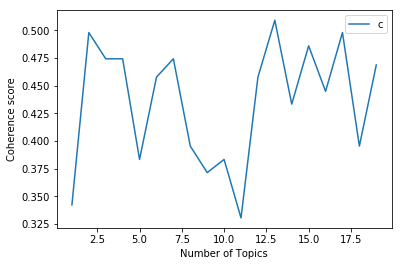

In [11]:
clean_text=preprocess_data(df['txt_en'])
start,stop,step=1,20,1
plot_graph(clean_text,start,stop,step)

In [36]:
model.show_topics()

[(0,
  '0.685*"u" + 0.367*"lord" + 0.254*"let" + 0.195*"mother" + 0.186*"son" + 0.183*"god" + 0.135*"give" + 0.126*"come" + 0.126*"world" + 0.108*"path"'),
 (1,
  '-0.670*"lord" + 0.320*"u" + 0.246*"mother" + -0.216*"alleluia" + 0.204*"son" + -0.196*"today" + -0.155*"trust" + -0.149*"god" + -0.132*"praise" + 0.128*"path"'),
 (2,
  '-0.775*"god" + 0.267*"lord" + 0.246*"today" + 0.219*"trust" + -0.170*"praise" + -0.131*"great" + -0.128*"king" + -0.116*"sing" + 0.101*"mother" + -0.092*"earth"'),
 (3,
  '0.616*"alleluia" + -0.383*"today" + -0.323*"trust" + -0.229*"god" + 0.215*"amen" + 0.184*"earth" + 0.177*"let" + 0.157*"rejoice" + 0.142*"joy" + 0.132*"call"'),
 (4,
  '0.447*"mother" + -0.358*"u" + 0.294*"son" + 0.229*"alleluia" + 0.207*"god" + 0.193*"trust" + -0.179*"let" + -0.155*"holy" + -0.149*"bread" + 0.148*"today"'),
 (5,
  '0.405*"jesus" + -0.385*"earth" + 0.374*"alleluia" + 0.340*"amen" + -0.206*"joy" + -0.199*"king" + -0.185*"whole" + -0.172*"call" + -0.147*"praise" + 0.141*"lov